In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [2]:
tweets = pd.read_csv('2022 Twitter Tweets Jan-April_Amber Heard Data.csv')
tweets

,id_str,created_at,full_text,lang,in_reply_to_status_id_str,in_reply_to_user_id,entities.hashtags,entities.media,entities.symbols,entities.urls,...,user.friends_count,user.lang,user.location,user.name,user.screen_name,user.profile_banner_url,user.profile_image_url,user.statuses_count,user.url,user.verified
0,1477504983130116096.0,2022-01-02 05:00:13+00:00,@la77465262 @Melinda15199317 @Dior So why is #...,en,1466075642244603909,1363630915298148352.0,"[{'indices': [45, 56], 'text': 'JohnnyDepp'}]","[{'original_info': {'width': 1058, 'focus_rect...",[],[],...,1898.0,NaN,NaN,Sean O'Connor,seano999,https://pbs.twimg.com/profile_banners/11497951...,http://pbs.twimg.com/profile_images/1442389537...,27033.0,NaN,False
1,1477503751716065280.0,2022-01-02 04:55:19+00:00,Only thing I want them to leave alone is the f...,en,NaN,NaN,[],NaN,[],[],...,1025.0,NaN,NaN,❤️‍🔥 Wilson the Opp Slayer 🔪,WonderWilson18,https://pbs.twimg.com/profile_banners/14262271...,http://pbs.twimg.com/profile_images/1515742990...,27853.0,https://t.co/dVvgQNht1k,False
2,1477499814719983616.0,2022-01-02 04:39:41+00:00,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,1477497121972621318,1297204830231040000.0,[],NaN,[],[],...,139.0,NaN,NaN,Steven Curry,StevenJCurry,https://pbs.twimg.com/profile_banners/14273589...,http://pbs.twimg.com/profile_images/1429534379...,199.0,NaN,False
3,1477497740498292736.0,2022-01-02 04:31:26+00:00,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,1477475212992073728,305017078.0,[],NaN,[],[],...,128.0,NaN,NaN,Vincent 1,Vincent72516869,NaN,http://pbs.twimg.com/profile_images/1354614785...,2313.0,NaN,False
4,1477496477484212224.0,2022-01-02 04:26:25+00:00,I never seen Aquaman nor will I because Amber ...,en,NaN,NaN,[],NaN,[],[],...,141.0,NaN,𝗡𝗢𝗧 𝗦𝗣𝗢𝗜𝗟𝗘𝗥 𝗙𝗥𝗘𝗘,𝐇𝐘𝐃𝐄,YoonJaysSimp,https://pbs.twimg.com/profile_banners/10769432...,http://pbs.twimg.com/profile_images/1516751870...,5423.0,https://t.co/XkBVR5FDCS,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508242,1515569901158600704,2022-04-17 05:56:37+00:00,Gender card pulled out. They are now spinning ...,en,NaN,NaN,[],NaN,[],[],...,201,NaN,NaN,ayyy nakoooo,GhelSandra,https://pbs.twimg.com/profile_banners/27013539...,http://pbs.twimg.com/profile_images/1402120521...,30280,https://t.co/KRDaAomcsU,False
508243,1515569890391961601,2022-04-17 05:56:34+00:00,Amber heard is a libra moon. Ive known a few l...,en,NaN,NaN,[],NaN,[],[],...,154,NaN,NaN,Jeli Bean,lilithrising_,https://pbs.twimg.com/profile_banners/14184202...,http://pbs.twimg.com/profile_images/1516523367...,7863,NaN,False
508244,1515569612686970883,2022-04-17 05:55:28+00:00,#JusticeForJohnnyDepp \n#JusticeForJohnnyDeppV...,und,NaN,NaN,"[{'indices': [0, 21], 'text': 'JusticeForJohnn...",NaN,[],[],...,647,NaN,"Colorado, USA",Cindy Moss🌱Ⓥ,CJMoss007,NaN,http://pbs.twimg.com/profile_images/1502775880...,6225,NaN,False
508245,1515569604818575368,2022-04-17 05:55:26+00:00,"Amber Heard is dating Eve Fartlow, Chelsea Man...",en,NaN,NaN,[],NaN,[],[],...,3214,NaN,"Rockford, Illinois",Jalopy Galopy,Jankem69420,https://pbs.twimg.com/profile_banners/13194711...,http://pbs.twimg.com/profile_images/1427306627...,9171,https://t.co/C6Pn7cxcss,False


In [3]:
df = tweets.filter(['full_text', 'lang'], axis=1)
df1 = df[df["lang"] == "en"]
df2 = df1.dropna()
df2.head()

,full_text,lang
0,@la77465262 @Melinda15199317 @Dior So why is #...,en
1,Only thing I want them to leave alone is the f...,en
2,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en
3,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en
4,I never seen Aquaman nor will I because Amber ...,en


# Data cleaning

In [6]:
# Remove non-English words

# remove punc 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())
# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
# new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use',"lah","haha","#","%"]
# stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [7]:
df2.head()

,full_text,lang,clean_text
0,@la77465262 @Melinda15199317 @Dior So why is #...,en,"[la77465262, melinda15199317, dior, johnnydepp..."
1,Only thing I want them to leave alone is the f...,en,"[thing, want, leave, alone, first, wonder, wom..."
2,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,"[soldierboy43001, zakreckless, yeah, snyder, i..."
3,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,"[iimissmax, bg98021, gerberkawasaki, forgot, h..."
4,I never seen Aquaman nor will I because Amber ...,en,"[never, seen, aquaman, amber, heard]"


In [8]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,lang,clean_text
0,@la77465262 @Melinda15199317 @Dior So why is #...,en,"[johnnydepp, case, evidence, court, johnny, mo..."
1,Only thing I want them to leave alone is the f...,en,"[thing, wonder, woman, movie, phase, aquaman, ..."
2,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,"[zakreckless, snyder, flash]"
3,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,"[hook, stress]"
4,I never seen Aquaman nor will I because Amber ...,en,[]


In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


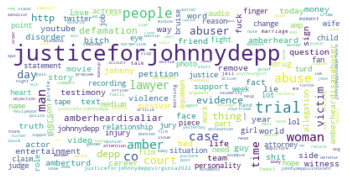

In [10]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

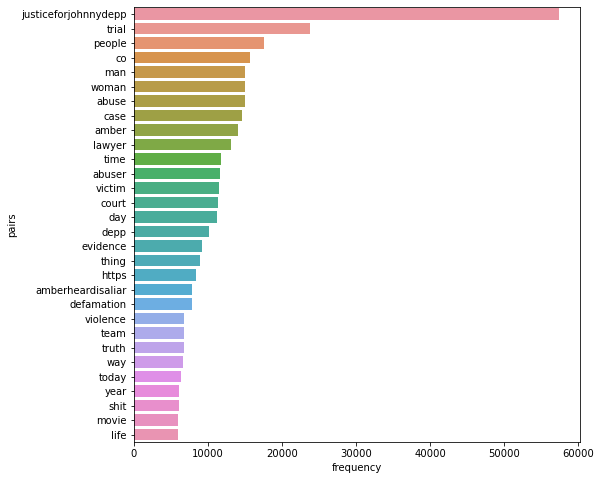

In [11]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [12]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['johnnydepp', 'case', 'evidence', 'court', 'johnny', 'money', 'reputation', 'fault', 'bringing', 'case', 'stan', 'waste', 'time'], ['thing', 'wonder', 'woman', 'movie', 'phase', 'aquaman', 'film'], ['zakreckless', 'snyder', 'flash']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'bringing'), (1, 'case'), (2, 'court'), (3, 'evidence'), (4, 'fault'), (5, 'johnny'), (6, 'johnnydepp'), (7, 'money'), (8, 'reputation'), (9, 'stan'), (10, 'time'), (11, 'waste'), (12, 'aquaman'), (13, 'film'), (14, 'movie'), (15, 'phase'), (16, 'thing'), (17, 'woman'), (18, 'wonder'), (19, 'flash'), (20, 'snyder'), (21, 'zakreckless'), (22, 'hook'), (23, 'stress'), (24, 'name'), (25, 'think'), (26, 'tinseltownmayor'), (27, 'justiceforjohnnydepp'), (28, 'bestie'), (29, 'boycott'), (30, 'receipt'), (31, 'abuser'), (32, 'myth'), (33, 'relationship'), (34, 'reminder'), (35, 'support'), (36, 'deal'), (37, 'attention'), (38, 'authority'), (39, 'celebrity'), (40, 'dog'), (41, 'fact'), (42, 'other'), (43, 'perjury'), (44, 'thatumbrella'), (45, 'heat'), (46, 'house'), (47, 'load'), (48, 'night'), (49, 'pipe')]

Total Vocabulary Size: 16333


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [15]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [16]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.41489762570727273
Perplexity Score:  -6.9434211821274125

topic number:  3
Coherence Score:  0.32940655188296436
Perplexity Score:  -6.999560289726982

topic number:  4
Coherence Score:  0.3517501405972649
Perplexity Score:  -7.085692439252821

topic number:  5
Coherence Score:  0.34444303008866706
Perplexity Score:  -7.121475513680507

topic number:  6
Coherence Score:  0.3448872039215503
Perplexity Score:  -7.1718374341690465

topic number:  7
Coherence Score:  0.32487906400373606
Perplexity Score:  -7.236470127022692

topic number:  8
Coherence Score:  0.3230253534600899
Perplexity Score:  -7.309742933880354

topic number:  9
Coherence Score:  0.360445110102355
Perplexity Score:  -7.390976607206216

topic number:  10
Coherence Score:  0.32629963287179253
Perplexity Score:  -7.601449615420949

topic number:  11
Coherence Score:  0.3145646400364937
Perplexity Score:  -7.918762910435241

topic number:  12
Coherence Score:  0.31957833925795226
Perple

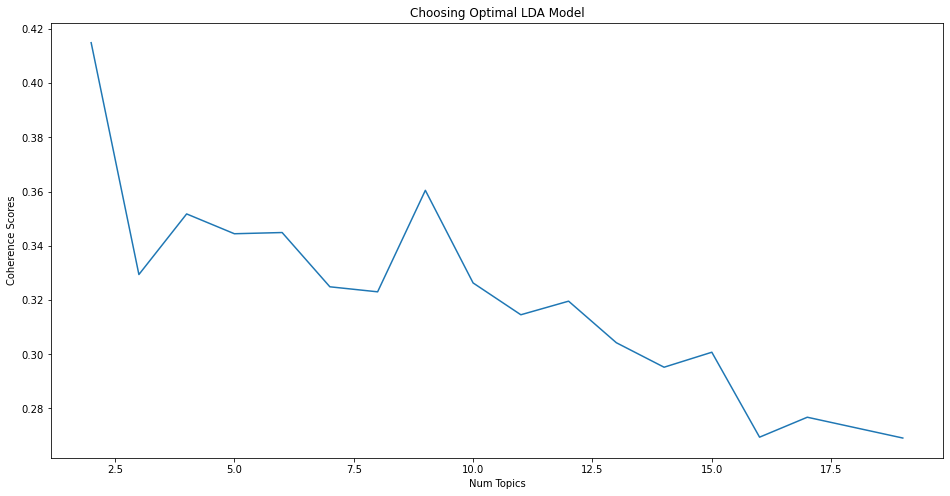

In [17]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [21]:
ntopics_des_name = 9

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [22]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.116*"co" + 0.106*"lawyer" + 0.064*"https" + 0.048*"question" + '
  '0.041*"trial" + 0.030*"youtube" + 0.026*"text" + 0.017*"court" + '
  '0.014*"muffin" + 0.013*"defense"'),
 (1,
  '0.127*"amber" + 0.040*"year" + 0.038*"face" + 0.028*"lawyer" + 0.025*"time" '
  '+ 0.021*"finger" + 0.017*"statement" + 0.015*"hour" + 0.014*"hand" + '
  '0.013*"article"'),
 (2,
  '0.073*"day" + 0.067*"justiceforjohnnydepp" + 0.035*"evidence" + '
  '0.029*"friend" + 0.021*"story" + 0.021*"guy" + 0.020*"drug" + 0.019*"court" '
  '+ 0.018*"video" + 0.017*"psychologist"'),
 (3,
  '0.069*"justiceforjohnnydepp" + 0.065*"amberheardisaliar" + '
  '0.042*"amberheardisanabuser" + 0.035*"lie" + 0.033*"attorney" + '
  '0.026*"money" + 0.022*"jury" + 0.022*"aquaman" + 0.020*"work" + '
  '0.018*"turd"'),
 (4,
  '0.112*"woman" + 0.111*"man" + 0.031*"life" + 0.030*"movie" + 0.027*"people" '
  '+ 0.022*"way" + 0.022*"support" + 0.020*"girl" + 0.018*"actor" + '
  '0.017*"fan"'),
 (5,
  '0.093*"abuse" + 0.070*"vic

In [23]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [24]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [25]:
df2['Topic'] = topic_num

In [26]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
0,@la77465262 @Melinda15199317 @Dior So why is #...,"[johnnydepp, case, evidence, court, johnny, mo...","[5, 8, 3]"
1,Only thing I want them to leave alone is the f...,"[thing, wonder, woman, movie, phase, aquaman, ...","[3, 4, 6, 8, 1, 2, 0, 5, 7]"
2,@soldierboy43001 @ZakReckless Yeah but Snyder ...,"[zakreckless, snyder, flash]","[3, 2, 1, 7, 0, 4, 8, 5, 6]"
3,@IIMissMax @bg98021 @GerberKawasaki You forgot...,"[hook, stress]","[1, 0, 2, 3, 4, 5, 6, 7, 8]"
4,I never seen Aquaman nor will I because Amber ...,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8]"


### Model Evaluation

In [27]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.393396669408204
Coherence Score:  0.3503786562849516


## Visualisation

In [28]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.237958 -0.054197       1        1  13.355333
5      0.104288 -0.185662       2        1  12.842676
2     -0.066501 -0.065239       3        1  12.552896
4     -0.111961 -0.115124       4        1  11.246041
8      0.214338 -0.142410       5        1  10.915067
0      0.245836  0.019141       6        1  10.278608
3     -0.267514  0.029369       7        1   9.844639
1      0.088664  0.122267       8        1   9.684829
7      0.030808  0.391856       9        1   9.279910, topic_info=                     Term          Freq         Total Category  logprob  \
27   justiceforjohnnydepp  59088.000000  59088.000000  Default  30.0000   
104                 trial  26044.000000  26044.000000  Default  29.0000   
213                 amber  15754.000000  15754.000000  Default  28.0000   
17                  woman  16205.000000  16205.000000  Default  27.0000   
63                    man  16064.000000  16064.000000  Default  26.0000   
..                    ...           ...           ...      ...      ...   
232               witness   3527.204869   5224.850012   Topic9  -3.5186   
89               argument   1148.752628   1389.988602   Topic9  -4.6404   
24                   name   1751.631513   2720.768487   Topic9  -4.2185   
231                   eye    749.094481   2165.775417   Topic9  -5.0680   
212                 proof    679.275170   1431.043355   Topic9  -5.1658   

     loglift  
27   30.0000  
104  29.0000  
213  28.0000  
17   27.0000  
63   26.0000  
..       ...  
232   1.9844  
89    2.1867  
24    1.9370  
231   1.3156  
212   1.6322  

[402 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
58        2  0.999939      abuse
31        2  0.803755     abuser
31        4  0.196207     abuser
146       4  0.737160    account
146       9  0.261918    account
...     ...       ...        ...
657       4  0.232393      world
82        2  0.182280       year
82        8  0.817599       year
2098      3  0.999406  yesterday
57        6  0.999680    youtube

[434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 3, 5, 9, 1, 4, 2, 8])

## Word Count of Topic Keywords

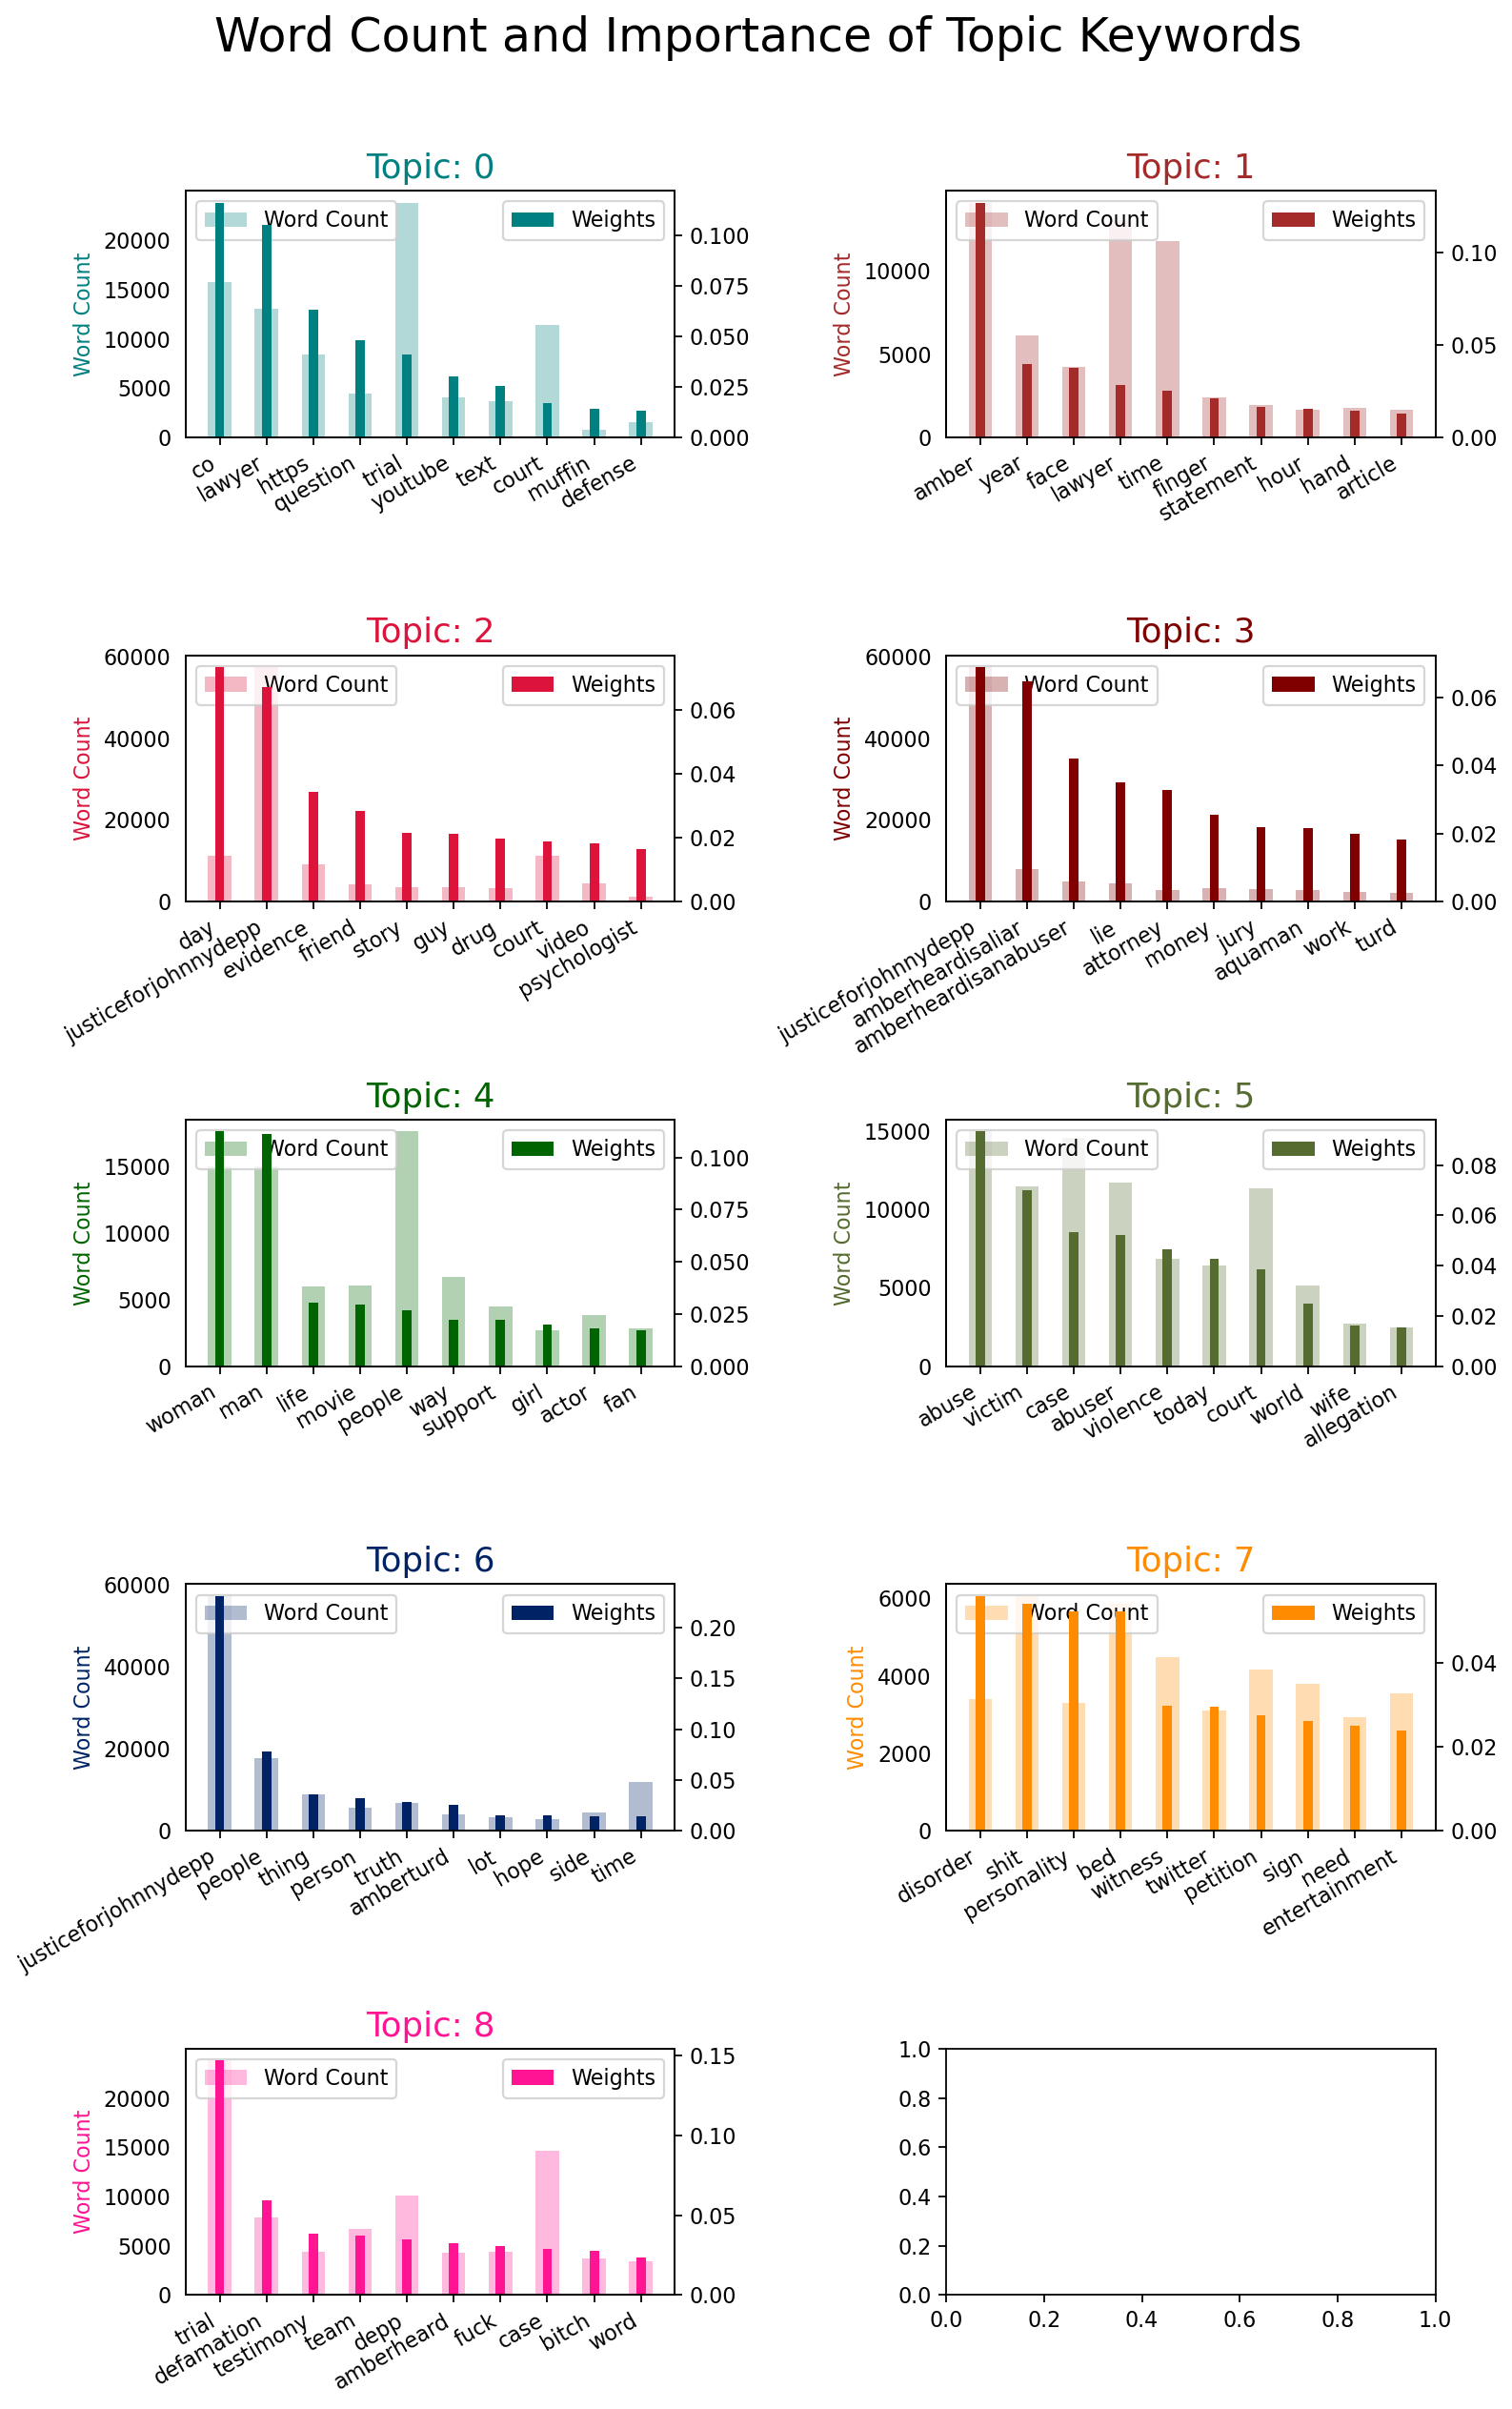

In [30]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
